# 2.A. Cleaning and Engineering -- Data Merging

In this notebook, we will take the time to merge our datasets together. We currently have data from the following sources:
 - Genius (Lyrical Data)
 - Spotify (Audio Data)
 - RapReviews, Pitchfork, and NeedleDrop (Review Data)
 
Previous attempts at **training a fuzzy match model to increase our match rates** across these datasets showed promise but will be explored in a later iteration of this project. For now, we will proceed with matching across *artist name, album name, and track name*. In order to execute this match, a number of steps will be taken:

 - For each data source...
  - Clean Artist Names (using regex and domain knowledge)
  - Clean Album Names (using regex and domain knowledge)
  - Clean Track Names (using regex and domain knowledge)
 - For each data source...
  - Manually comb through Artist and Album Names in excel
  - Change Artist/Album based on patterns seen manually
  - Change these values within our respective Dataframes

With the data combined, we just have a few more cleaning tasks to execute:

 - Remove tracks that do not have *rap* as genre
 
**NOTE:** There is a significant amount of manual work that went into the combination of these files. As such, several data sets are read in and out over the course of the notebook. As a result, this notebook, more than others, will be more difficult to follow.


In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import time
import requests
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import lyricsgenius
import re
import sys
import spotipy
import spotipy.util as util
from sklearn.compose import ColumnTransformer, make_column_transformer
from pyjarowinkler import distance
import nltk

import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import time
import requests
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB


In [890]:
pitchfork = pd.read_csv('pitchfork_deduped_final.csv')
rr = pd.read_csv('./rapreview/ready_to_combine.csv')
needle = pd.read_csv('./needledrop/combined_needle_review_data.csv')

In [891]:
spotify = pd.read_csv('spotify_final_230k.csv')

C:\Users\Owen\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (4,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [317]:
genius = pd.read_csv('saturday_done.csv')

## Clean Artist, Album Names

In [36]:
pitchfork['artist_clean'] = pitchfork['artist'].str.replace('$', 'S')
pitchfork['artist_clean'] = pitchfork['artist_clean'].str.replace("’", "")
pitchfork['artist_clean'] = pitchfork['artist_clean'].str.replace('&', 'and')
pitchfork['artist_clean'] = pitchfork['artist_clean'].str.replace('!','') 
pitchfork['artist_clean'] = pitchfork['artist_clean'].str.replace('([ ]{2,})', ' ', regex = True) 
pitchfork['artist_clean'] = pitchfork['artist_clean'].str.strip()
pitchfork['artist_clean'] = pitchfork['artist_clean'].str.lower()

In [42]:
pitchfork['album_name_clean'] = pitchfork['album'].str.replace('$', 'S')

pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace(' EP', '')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace(' LP', '')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.lower()



pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('edition', '')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('version', '')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('deluxe', '')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('reissue', '')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('remastered', '')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace(' ots', '')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('(original motion picture soundtrack)', '')

pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('volume one', 'volume 1')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('volume two', 'volume 2')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('volume three', 'volume 3')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('volume four', 'volume 4')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('volume five', 'volume 5')

pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('volume 1', 'vol 1')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('volume 2', 'vol 2')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('volume 3', 'vol 3')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('volume 4', 'vol 4')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('volume 5', 'vol 5')

pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('vol 1', 'vol1')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('vol 2', 'vol2')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('vol 3', 'vol3')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('vol 4', 'vol4')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('vol 5', 'vol5')

pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('vol1', 'v1')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('vol2', 'v2')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('vol3', 'v3')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('vol4', 'v4')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('vol5', 'v5')

pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('iii', '3')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('ii', '2')

pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace(' i ', '1')


pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace("’", "")
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace("'", "")
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('&', 'and')
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('!', '') 
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace("([\(\[]).*?([\)\]])", '', regex = True)
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.replace('([ ]{2,})', ' ', regex = True) 
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.strip()
pitchfork['album_name_clean'] = pitchfork['album_name_clean'].str.lower()


In [31]:
pitchfork_df['artist_album'] = pitchfork_df.artist.str.lower().str.strip() + '|' + pitchfork_df.album.str.lower().str.strip()
rr_df['artist_album'] = rr_df.artist_name.str.lower().str.strip() + '|' + rr_df.album_name.str.lower().str.strip()
needle_df['artist_album'] = needle_df.artist.str.lower().str.strip() + '|' + needle_df.title.str.lower().str.strip()

In [186]:
needle['artist_clean'] = needle['artist'].str.replace('$', 'S')
needle['artist_clean'] = needle['artist_clean'].str.replace("’", "")
needle['artist_clean'] = needle['artist_clean'].str.replace('&', 'and')
needle['artist_clean'] = needle['artist_clean'].str.replace('!','') 
needle['artist_clean'] = needle['artist_clean'].str.replace('([ ]{2,})', ' ', regex = True) 
needle['artist_clean'] = needle['artist_clean'].str.strip()
needle['artist_clean'] = needle['artist_clean'].str.lower()

In [187]:
needle['album_name_clean'] = needle['title'].str.replace('$', 'S')

needle['album_name_clean'] = needle['album_name_clean'].str.replace(' EP', '')
needle['album_name_clean'] = needle['album_name_clean'].str.replace(' LP', '')
needle['album_name_clean'] = needle['album_name_clean'].str.lower()



needle['album_name_clean'] = needle['album_name_clean'].str.replace('edition', '')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('version', '')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('deluxe', '')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('reissue', '')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('remastered', '')
needle['album_name_clean'] = needle['album_name_clean'].str.replace(' ots', '')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('(original motion picture soundtrack)', '')

needle['album_name_clean'] = needle['album_name_clean'].str.replace('volume one', 'volume 1')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('volume two', 'volume 2')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('volume three', 'volume 3')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('volume four', 'volume 4')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('volume five', 'volume 5')

needle['album_name_clean'] = needle['album_name_clean'].str.replace('volume 1', 'vol 1')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('volume 2', 'vol 2')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('volume 3', 'vol 3')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('volume 4', 'vol 4')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('volume 5', 'vol 5')

needle['album_name_clean'] = needle['album_name_clean'].str.replace('vol 1', 'vol1')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('vol 2', 'vol2')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('vol 3', 'vol3')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('vol 4', 'vol4')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('vol 5', 'vol5')

needle['album_name_clean'] = needle['album_name_clean'].str.replace('vol1', 'v1')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('vol2', 'v2')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('vol3', 'v3')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('vol4', 'v4')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('vol5', 'v5')

needle['album_name_clean'] = needle['album_name_clean'].str.replace('iii', '3')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('ii', '2')

needle['album_name_clean'] = needle['album_name_clean'].str.replace(' i ', '1')


needle['album_name_clean'] = needle['album_name_clean'].str.replace("’", "")
needle['album_name_clean'] = needle['album_name_clean'].str.replace("'", "")
needle['album_name_clean'] = needle['album_name_clean'].str.replace('&', 'and')
needle['album_name_clean'] = needle['album_name_clean'].str.replace('!', '') 
needle['album_name_clean'] = needle['album_name_clean'].str.replace("([\(\[]).*?([\)\]])", '', regex = True)
needle['album_name_clean'] = needle['album_name_clean'].str.replace('([ ]{2,})', ' ', regex = True) 
needle['album_name_clean'] = needle['album_name_clean'].str.strip()
needle['album_name_clean'] = needle['album_name_clean'].str.lower()


In [49]:
rr['artist_clean'] = rr['artist_name'].str.replace('$', 'S')
rr['artist_clean'] = rr['artist_clean'].str.replace("’", "")
rr['artist_clean'] = rr['artist_clean'].str.replace('&', 'and')
rr['artist_clean'] = rr['artist_clean'].str.replace('!','') 
rr['artist_clean'] = rr['artist_clean'].str.replace('([ ]{2,})', ' ', regex = True) 
rr['artist_clean'] = rr['artist_clean'].str.strip()
rr['artist_clean'] = rr['artist_clean'].str.lower()


In [50]:
rr['album_name_clean'] = rr['album_name'].str.replace('$', 'S')

rr['album_name_clean'] = rr['album_name_clean'].str.replace(' EP', '')
rr['album_name_clean'] = rr['album_name_clean'].str.replace(' LP', '')
rr['album_name_clean'] = rr['album_name_clean'].str.lower()



rr['album_name_clean'] = rr['album_name_clean'].str.replace('edition', '')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('version', '')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('deluxe', '')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('reissue', '')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('remastered', '')
rr['album_name_clean'] = rr['album_name_clean'].str.replace(' ots', '')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('(original motion picture soundtrack)', '')

rr['album_name_clean'] = rr['album_name_clean'].str.replace('volume one', 'volume 1')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('volume two', 'volume 2')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('volume three', 'volume 3')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('volume four', 'volume 4')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('volume five', 'volume 5')

rr['album_name_clean'] = rr['album_name_clean'].str.replace('volume 1', 'vol 1')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('volume 2', 'vol 2')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('volume 3', 'vol 3')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('volume 4', 'vol 4')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('volume 5', 'vol 5')

rr['album_name_clean'] = rr['album_name_clean'].str.replace('vol 1', 'vol1')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('vol 2', 'vol2')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('vol 3', 'vol3')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('vol 4', 'vol4')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('vol 5', 'vol5')

rr['album_name_clean'] = rr['album_name_clean'].str.replace('vol1', 'v1')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('vol2', 'v2')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('vol3', 'v3')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('vol4', 'v4')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('vol5', 'v5')

rr['album_name_clean'] = rr['album_name_clean'].str.replace('iii', '3')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('ii', '2')

rr['album_name_clean'] = rr['album_name_clean'].str.replace(' i ', '1')


rr['album_name_clean'] = rr['album_name_clean'].str.replace("’", "")
rr['album_name_clean'] = rr['album_name_clean'].str.replace("'", "")
rr['album_name_clean'] = rr['album_name_clean'].str.replace('&', 'and')
rr['album_name_clean'] = rr['album_name_clean'].str.replace('!', '') 
rr['album_name_clean'] = rr['album_name_clean'].str.replace("([\(\[]).*?([\)\]])", '', regex = True)
rr['album_name_clean'] = rr['album_name_clean'].str.replace('([ ]{2,})', ' ', regex = True) 
rr['album_name_clean'] = rr['album_name_clean'].str.strip()
rr['album_name_clean'] = rr['album_name_clean'].str.lower()


In [318]:
genius['artist_clean'] = genius['artist'].str.replace('$', 'S')
genius['artist_clean'] = genius['artist_clean'].str.replace("’", "")
genius['artist_clean'] = genius['artist_clean'].str.replace('&', 'and')
genius['artist_clean'] = genius['artist_clean'].str.replace('!','') 
genius['artist_clean'] = genius['artist_clean'].str.replace('([ ]{2,})', ' ', regex = True) 
genius['artist_clean'] = genius['artist_clean'].str.strip()
genius['artist_clean'] = genius['artist_clean'].str.lower()

In [319]:
genius['album_name_clean'] = genius['album'].str.replace('$', 'S')

genius['album_name_clean'] = genius['album_name_clean'].str.replace(' EP', '')
genius['album_name_clean'] = genius['album_name_clean'].str.replace(' LP', '')
genius['album_name_clean'] = genius['album_name_clean'].str.lower()



genius['album_name_clean'] = genius['album_name_clean'].str.replace('edition', '')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('version', '')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('deluxe', '')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('reissue', '')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('remastered', '')
genius['album_name_clean'] = genius['album_name_clean'].str.replace(' ots', '')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('(original motion picture soundtrack)', '')

genius['album_name_clean'] = genius['album_name_clean'].str.replace('volume one', 'volume 1')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('volume two', 'volume 2')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('volume three', 'volume 3')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('volume four', 'volume 4')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('volume five', 'volume 5')

genius['album_name_clean'] = genius['album_name_clean'].str.replace('volume 1', 'vol 1')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('volume 2', 'vol 2')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('volume 3', 'vol 3')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('volume 4', 'vol 4')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('volume 5', 'vol 5')

genius['album_name_clean'] = genius['album_name_clean'].str.replace('vol 1', 'vol1')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('vol 2', 'vol2')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('vol 3', 'vol3')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('vol 4', 'vol4')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('vol 5', 'vol5')

genius['album_name_clean'] = genius['album_name_clean'].str.replace('vol1', 'v1')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('vol2', 'v2')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('vol3', 'v3')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('vol4', 'v4')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('vol5', 'v5')


genius['album_name_clean'] = genius['album_name_clean'].str.replace("’", "")
genius['album_name_clean'] = genius['album_name_clean'].str.replace("'", "")
genius['album_name_clean'] = genius['album_name_clean'].str.replace('&', 'and')
genius['album_name_clean'] = genius['album_name_clean'].str.replace('!', '') 
genius['album_name_clean'] = genius['album_name_clean'].str.replace("([\(\[]).*?([\)\]])", '', regex = True)
genius['album_name_clean'] = genius['album_name_clean'].str.replace('([ ]{2,})', ' ', regex = True) 
genius['album_name_clean'] = genius['album_name_clean'].str.strip()
genius['album_name_clean'] = genius['album_name_clean'].str.lower()

In [892]:
spotify['artist_clean'] = spotify['arist_y'].str.replace('$', 'S')
spotify['artist_clean'] = spotify['artist_clean'].str.replace("’", "")
spotify['artist_clean'] = spotify['artist_clean'].str.replace('&', 'and')
spotify['artist_clean'] = spotify['artist_clean'].str.replace('!', '') 
spotify['artist_clean'] = spotify['artist_clean'].str.replace('([ ]{2,})', ' ', regex = True) 
spotify['artist_clean'] = spotify['artist_clean'].str.strip()
spotify['artist_clean'] = spotify['artist_clean'].str.lower()

In [893]:
spotify['album_name_clean'] = spotify['album_name'].str.replace('$', 'S')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace(' LP', '')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace(' EP', '')
spotify['album_name_clean'] = spotify['album_name_clean'].str.lower()


spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('edition', '')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('version', '')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('deluxe', '')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('reissue', '')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('remastered', '')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace(' ots', ' ')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('(original motion picture soundtrack)', '')


spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('volume one', 'volume 1')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('volume two', 'volume 2')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('volume three', 'volume 3')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('volume four', 'volume 4')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('volume five', 'volume 5')

spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('volume 1', 'vol 1')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('volume 2', 'vol 2')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('volume 3', 'vol 3')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('volume 4', 'vol 4')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('volume 5', 'vol 5')

spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('vol 1', 'vol1')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('vol 2', 'vol2')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('vol 3', 'vol3')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('vol 4', 'vol4')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('vol 5', 'vol5')

spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('vol1', 'v1')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('vol2', 'v2')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('vol3', 'v3')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('vol4', 'v4')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('vol5', 'v5')



spotify['album_name_clean'] = spotify['album_name_clean'].str.replace("’", "")
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace("'", "")
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('&', 'and')
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('!', '') 
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace("([\(\[]).*?([\)\]])", '', regex = True)
spotify['album_name_clean'] = spotify['album_name_clean'].str.replace('([ ]{2,})', ' ', regex = True) 
spotify['album_name_clean'] = spotify['album_name_clean'].str.strip()

## Pivot Artist Names

In [60]:
## Clean Artist, Album Names

In [61]:
needle_name_df = pd.DataFrame(needle['artist_clean'].unique()).rename(columns={0:'names'})
needle_name_df['source'] = 'needle'

In [62]:
rr_name_df = pd.DataFrame(rr['artist_clean'].unique()).rename(columns={0:'names'})
rr_name_df['source'] = 'rr'

In [73]:
genius_name_df = pd.DataFrame(genius['artist_clean'].unique()).rename(columns={0:'names'})
genius_name_df['source'] = 'genius'

In [74]:
# spotify_name_df = pd.DataFrame(spotify['artist_clean'].unique()).rename(columns={0:'names'})
# spotify_name_df['source'] = 'spot'

In [74]:
spotify_name_df = pd.DataFrame(spotify['artist_clean'].unique()).rename(columns={0:'names'})
spotify_name_df['source'] = 'spot'

In [75]:
name_df = pd.concat([pitchfork_name_df, needle_name_df,rr_name_df, spotify_name_df, genius_name_df])

In [84]:
name_df = pd.pivot(name_df, index='names',columns='source', values='source')

In [85]:
name_df = name_df.fillna(0)

In [91]:
name_df.loc[name_df.genius != 0, 'genius'] = 1
name_df.loc[name_df.needle != 0, 'needle'] = 1
name_df.loc[name_df.pitch != 0, 'pitch'] = 1
name_df.loc[name_df.rr != 0, 'rr'] = 1
name_df.loc[name_df.spot != 0, 'spot'] = 1

In [93]:
name_df['total'] = name_df['genius'] + name_df['needle'] + name_df['pitch'] + name_df['rr']+ name_df['spot']

In [99]:
name_df = name_df.sort_values('total', ascending=False)

***
## Read in Manually Cleaned Artist Names

In [104]:
name_amend_df = pd.read_csv('name_analysis_return.csv')

In [106]:
name_amend_df

,artist,corrected
0,8 ball 8 ways entertainment,8ball
1,8 ball mjg,8ball
2,8 mile and shit,8ball
3,8ball and devius,8ball
4,8ball featuring e.d.i. of the outlawz,8ball
...,...,...
361,"talib kweli, 9th wonder",talib kweli
362,travis scott,travis scott
363,travis scott and quavo,travis scott
364,waka flocka flame,waka flocka flame


### Left Join and Replace Names (Genius)

In [320]:
genius = pd.merge(genius,name_amend_df, left_on='artist_clean', right_on='artist', how='left')

In [321]:
for index, row, in genius.loc[genius['corrected'].notnull()].iterrows():
    genius.iloc[index,7] = genius.iloc[index,10]


In [322]:
genius = genius.drop(columns=['artist_y','corrected']).rename(columns={'artist_x':'artist'})

### Left Join and Replace Names (Spotify)

In [331]:
spotify = pd.merge(spotify,name_amend_df, left_on='artist_clean', right_on='artist', how='left')

In [332]:
for index, row, in spotify.loc[spotify['corrected'].notnull()].iterrows():
    spotify.iloc[index,-3] = spotify.iloc[index,-1]

In [333]:
spotify.columns

Index(['acousticness', 'album_id', 'album_name', 'analysis_url', 'arist_x',
       'artist_id', 'danceability', 'duration_ms', 'energy', 'follower_x',
       'genres_x', 'id', 'image_x', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'pop_x', 'preview_url', 'speechiness', 'tempo',
       'time_signature', 'track_href', 'track_id', 'track_name', 'type', 'uri',
       'valence', 'arist_y', 'genres_y', 'image_y', 'pop_y', 'follower_y',
       'artist_clean', 'album_name_clean', 'artist', 'corrected'],
      dtype='object')

In [334]:
spotify = spotify.drop(columns=['arist_x', 'artist', 'corrected'])

### Left Join and Replace Names (Needle)

In [188]:
needle = pd.merge(needle,name_amend_df, left_on='artist_clean', right_on='artist', how='left')

In [189]:
needle.columns

Index(['artist_x', 'best_tracks', 'caption', 'link', 'review_date',
       'review_type', 'score', 'title', 'video_id', 'word_score',
       'worst_track', 'artist_clean', 'album_name_clean', 'artist_y',
       'corrected'],
      dtype='object')

In [190]:
for index, row, in needle.loc[needle['corrected'].notnull()].iterrows():
    needle.iloc[index,-4] = needle.iloc[index,-1]

In [191]:
needle = needle.drop(columns=['artist_y','corrected'])

### Left Join and Replace Names (RR)

In [182]:
rr = pd.merge(rr,name_amend_df, left_on='artist_clean', right_on='artist', how='left')

In [183]:
rr.columns

Index(['artist_name', 'album_name', 'cleaned_text', 'artist_clean',
       'album_name_clean', 'artist', 'corrected'],
      dtype='object')

In [192]:
for index, row, in rr.loc[rr['corrected'].notnull()].iterrows():
    rr.iloc[index,-4] = rr.iloc[index,-1]

In [194]:
rr = rr.drop(columns=['artist','corrected'])

### Left Join and Replace Names (Pitchfork)

In [195]:
pitchfork = pd.merge(pitchfork,name_amend_df, left_on='artist_clean', right_on='artist', how='left')

In [196]:
pitchfork.columns

Index(['album', 'artist_x', 'editorial', 'full_text', 'matched_album',
       'matched_artist', 'score', 'spotify_album_name', 'spotify_artist',
       'url', 'year', 'artist_clean', 'album_name_clean', 'artist_y',
       'corrected'],
      dtype='object')

In [197]:
for index, row, in pitchfork.loc[pitchfork['corrected'].notnull()].iterrows():
    pitchfork.iloc[index,-4] = pitchfork.iloc[index,-1]

In [198]:
pitchfork = pitchfork.drop(columns=['artist_y','corrected'])

***
# ALBUMS

### Build Albums Pivot

In [290]:
needle_album_df = pd.DataFrame(needle['album_name_clean'].unique()).rename(columns={0:'names'})
needle_album_df['source'] = 'needle'

In [291]:
rr_album_df = pd.DataFrame(rr['album_name_clean'].unique()).rename(columns={0:'names'})
rr_album_df['source'] = 'rr'

In [292]:
genius_album_df = pd.DataFrame(genius['album_name_clean'].unique()).rename(columns={0:'names'})
genius_album_df['source'] = 'genius'

In [293]:
spotify_album_df = pd.DataFrame(spotify['album_name_clean'].unique()).rename(columns={0:'names'})
spotify_album_df['source'] = 'spot'

In [294]:
pitchfork_album_df = pd.DataFrame(pitchfork['album_name_clean'].unique()).rename(columns={0:'names'})
pitchfork_album_df['source'] = 'pitch'

In [295]:
album_df = pd.concat([pitchfork_album_df, needle_album_df,rr_album_df, spotify_album_df, genius_album_df])

In [296]:
album_df = pd.pivot(album_df, index='names',columns='source', values='source')

In [297]:
album_df = album_df.fillna(0)

In [298]:
album_df.loc[album_df.genius != 0, 'genius'] = 1
album_df.loc[album_df.needle != 0, 'needle'] = 1
album_df.loc[album_df.pitch != 0, 'pitch'] = 1
album_df.loc[album_df.rr != 0, 'rr'] = 1
album_df.loc[album_df.spot != 0, 'spot'] = 1

In [299]:
album_df['total'] = album_df['genius'] + album_df['needle'] + album_df['pitch'] + album_df['rr']+ album_df['spot']

In [300]:
album_df= album_df.sort_values('total', ascending=False)

In [304]:
album_df.to_csv('album_analysis.csv')

### Read in Corrections

In [306]:
album_amend_df = pd.read_csv('album_analysis_return.csv')

In [307]:
album_amend_df.columns

Index(['names', 'corrected'], dtype='object')

## Apply Corrections

### Left Join and Adjust Genius

In [309]:
genius.columns

Index(['album', 'artist', 'date', 'features', 'lyrics', 'producers', 'song',
       'artist_clean', 'album_name_clean', 'names', 'corrected'],
      dtype='object')

In [323]:
genius = pd.merge(genius,album_amend_df, left_on='album_name_clean', right_on='names', how='left')

In [324]:
for index, row, in genius.loc[genius['corrected'].notnull()].iterrows():
    genius.iloc[index,-3] = genius.iloc[index,-1]


In [325]:
genius = genius.drop(columns=['names','corrected'])

### Left Join and Adjust Spotify

In [335]:
spotify = pd.merge(spotify,album_amend_df, left_on='album_name_clean', right_on='names', how='left')

In [336]:
for index, row, in spotify.loc[spotify['corrected'].notnull()].iterrows():
    spotify.iloc[index,-4] = spotify.iloc[index,-1]


In [340]:
spotify = spotify.drop(columns=['names','corrected'])

### Left Join and Adjust Needle

In [341]:
needle = pd.merge(needle,album_amend_df, left_on='album_name_clean', right_on='names', how='left')

In [342]:
needle.columns

Index(['artist_x', 'best_tracks', 'caption', 'link', 'review_date',
       'review_type', 'score', 'title', 'video_id', 'word_score',
       'worst_track', 'artist_clean', 'album_name_clean', 'names',
       'corrected'],
      dtype='object')

In [343]:
for index, row, in needle.loc[needle['corrected'].notnull()].iterrows():
    needle.iloc[index,-3] = needle.iloc[index,-1]

In [344]:
needle = needle.drop(columns=['names','corrected'])

### Left Join and Adjust RR

In [345]:
rr = pd.merge(rr,album_amend_df, left_on='album_name_clean', right_on='names', how='left')

In [346]:
rr.columns

Index(['artist_name', 'album_name', 'cleaned_text', 'artist_clean',
       'album_name_clean', 'names', 'corrected'],
      dtype='object')

In [347]:
for index, row, in rr.loc[rr['corrected'].notnull()].iterrows():
    rr.iloc[index,-3] = rr.iloc[index,-1]

In [348]:
rr = rr.drop(columns=['names','corrected'])

### Left Join and Adjust Pitch

In [349]:
pitchfork = pd.merge(pitchfork,album_amend_df, left_on='album_name_clean', right_on='names', how='left')

In [350]:
pitchfork.columns

Index(['album', 'artist_x', 'editorial', 'full_text', 'matched_album',
       'matched_artist', 'score', 'spotify_album_name', 'spotify_artist',
       'url', 'year', 'artist_clean', 'album_name_clean', 'names',
       'corrected'],
      dtype='object')

In [351]:
for index, row, in pitchfork.loc[pitchfork['corrected'].notnull()].iterrows():
    pitchfork.iloc[index,-3] = pitchfork.iloc[index,-1]

In [352]:
pitchfork = pitchfork.drop(columns=['names','corrected'])

## Build Combined Album DF

In [353]:
pitchfork.to_csv('./combining/albumdata/pitchfork_updated.csv', index=False)
needle.to_csv('./combining/albumdata/needle_updated.csv', index=False)
rr.to_csv('./combining/albumdata/rr_updated.csv', index=False)

In [358]:
pitchfork['artist_album_clean_key'] = pitchfork['artist_clean'] + "|" + pitchfork['album_name_clean']
rr['artist_album_clean_key'] = rr['artist_clean'] + "|" + rr['album_name_clean']
needle['artist_album_clean_key'] = needle['artist_clean'] + "|" + needle['album_name_clean']

In [368]:
pitchfork_merge_df = pitchfork[['artist_album_clean_key', 'full_text']].rename(columns={'full_text': 'review'})
rr_merge_df = rr[['artist_album_clean_key', 'cleaned_text']].rename(columns={'cleaned_text': 'review'})
needle_merge_df = needle[['artist_album_clean_key', 'caption']].rename(columns={'caption': 'review'})

In [371]:
pitchfork_merge_df['source'] = 'pitchfork'
rr_merge_df['source'] = 'rr'
needle_merge_df['source'] = 'needle'

In [372]:
review_df = pd.concat([pitchfork_merge_df, needle_merge_df,rr_merge_df])

In [870]:
review_df = pd.read_csv('./combining/albumdata/allreviews_concat.csv')

## Track Clean

In [597]:
genius['track_clean'] = genius['song'].str.lower()
genius['track_clean'] = genius['track_clean'].str.replace(r"([\(\[]).*?([\)\]])", '')
genius['track_clean'] = genius['track_clean'].str.replace(r"[^\w\s]",'')
genius['track_clean'] = genius['track_clean'].str.replace(r"([ ]{2,})",' ')
genius['track_clean'] = genius['track_clean'].str.strip()


In [894]:
spotify['track_clean'] = spotify['track_name'].str.lower()
spotify['track_clean'] = spotify['track_clean'].str.replace(r"([\(\[]).*?([\)\]])", '')
spotify['track_clean'] = spotify['track_clean'].str.replace(r"[^\w\s]",'')
spotify['track_clean'] = spotify['track_clean'].str.replace(r"([ ]{2,})",' ')
spotify['track_clean'] = spotify['track_clean'].str.strip()


## Album -- Imputation for Genius

In [535]:
genius_df.album_name_clean.isnull().sum()

6887

In [895]:
genius['artist_track_join_for_album'] = genius['artist_clean'] + "|" + genius['track_clean']
spotify['artist_track_join_for_album'] = spotify['artist_clean'] + "|" + spotify['track_clean']

In [619]:
deduped_genius_artist_track_list_needs_album = list(genius.loc[genius['album_name_clean'].isnull(),'artist_track_join_for_album'].unique())

In [606]:
deduped_imput_list_candidates = list(spotify['artist_track_join_for_album'].unique())

In [607]:
len(deduped_imput_list_candidates)

194920

In [622]:
impute_list = []

for artist_track in deduped_genius_artist_track_list_needs_album:
    
    if artist_track in deduped_imput_list_candidates:
        impute_list.append(artist_track)

In [631]:
spotify.loc[spotify['artist_track_join_for_album'].isin(deduped_genius_artist_track_list_needs_album), ['artist_track_join_for_album', 'album_name_clean']].to_csv('./combining/albumimputation/spotify_imputation_values.csv', index=False)

In [635]:
genius.to_csv('./combining/albumimputation/genius_imputation_values.csv', index=False)

In [896]:
genius_cleaner = pd.read_csv('./combining/albumimputation/genius_imputation_results.csv')

## Combining

In [897]:
spotify['album_track_clean_key'] = spotify['album_name_clean'] + "|" + spotify['track_clean']

In [898]:
genius_cleaner = genius_cleaner.drop_duplicates('artist_track_join_for_album')

In [899]:
genius_cleaner.columns

Index(['album', 'artist', 'date', 'features', 'lyrics', 'producers', 'song',
       'artist_clean', 'album_name_clean', 'track_clean',
       'artist_track_join_for_album'],
      dtype='object')

In [900]:
genius_cleaner['artist_album_clean_key'] = genius_cleaner['artist_clean'] + "|" + genius_cleaner['album_name_clean']
genius_cleaner['album_track_clean_key'] = genius_cleaner['album_name_clean'] + "|" + genius_cleaner['track_clean']

In [901]:
genius_cleaner.isnull().sum()

album                           6060
artist                             0
date                           12058
features                           0
lyrics                             4
producers                          0
song                               0
artist_clean                       0
album_name_clean                5578
track_clean                       10
artist_track_join_for_album        0
artist_album_clean_key          5578
album_track_clean_key           5583
dtype: int64

In [902]:
temp = pd.merge(genius_cleaner, spotify, how='left', on='artist_track_join_for_album')

In [903]:
temp2 = pd.merge(genius_cleaner, spotify, how='left', on='album_track_clean_key')

In [904]:
temp['artist_track'] = temp['artist'] +"|" + temp['song']

In [905]:
temp['artist_album_clean_key'] = temp['artist_clean_x'] + "|" + temp['album_name_clean_x']

In [906]:
temp.shape, temp2.shape

((52219, 52), (47753, 51))

In [907]:
temp = temp.drop_duplicates('artist_track')

In [908]:
temp.shape

(44340, 52)

## Adding in reviews

In [909]:
temp2 = temp[temp['arist_y'].notnull()]

In [910]:
temp2.shape

(23497, 52)

In [752]:
everything = pd.merge(temp2, review_df, how='left', on='artist_album_clean_key')

In [753]:
everything.to_csv('./combining/everything_manual_check.csv' ,index=False )

In [759]:
everything = pd.read_csv('./combining/everything_manual_check.csv', encoding="ISO-8859-1")

C:\Users\Owen\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (13,18,19,27,32,33,34,43,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [778]:
everything.columns

Index(['album', 'artist', 'date', 'features', 'lyrics', 'producers', 'song',
       'artist_clean', 'album_name_clean', 'track_clean', 'acousticness',
       'album_id', 'album_name', 'artist_id', 'danceability', 'duration_ms',
       'energy', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'preview_url', 'speechiness', 'tempo', 'time_signature',
       'track_href', 'track_id', 'track_name', 'uri', 'valence', 'genres',
       'pop', 'follower', 'combined_reviews'],
      dtype='object')

In [765]:
everything = everything.drop(columns=['follower_x', 'genres_x', 'image_x', 'pop_x', 'rr_review', 'pitch_review', 'needle_review'])

In [769]:
everything = everything.drop(columns=['artist_track_join_for_album', 'artist_album_clean_key', 'album_track_clean_key_x', 'analysis_url', 'arist_y', 'artist_clean_y', 'album_name_clean_y'])

In [772]:
everything = everything.drop(columns=['type', 'image_y', 'track_clean_y', 'album_track_clean_key_y', 'artist_y', 'album_y'])

In [776]:
everything = everything.rename(columns={'album_x':'album', 'artist_x':'artist','artist_clean_x':'artist_clean'})
everything = everything.rename(columns={'album_name_clean_x':'album_name_clean',
                                'track_clean_x':'track_clean',
                                'follower_y':'follower',
                                'genres_y':'genres',
                                'pop_y':'pop'})

In [779]:
everything.to_csv('everything_ready_for_lyrics.csv', index=False)

****
# Cleaning Combined Data Set

In [2]:
songs = pd.read_csv('everything_ready_for_lyrics.csv')

C:\Users\Owen\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (10,14,15,20,24,25,26,33,34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
songs.shape, songs.columns

((29008, 36),
 Index(['album', 'artist', 'date', 'features', 'lyrics', 'producers', 'song',
        'artist_clean', 'album_name_clean', 'track_clean', 'acousticness',
        'album_id', 'album_name', 'artist_id', 'danceability', 'duration_ms',
        'energy', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
        'mode', 'preview_url', 'speechiness', 'tempo', 'time_signature',
        'track_href', 'track_id', 'track_name', 'uri', 'valence', 'genres',
        'pop', 'follower', 'combined_reviews'],
       dtype='object'))

In [4]:
songs = songs.drop(columns = ['combined_reviews'])

### Artist

In [5]:
songs = songs[songs.artist_clean.str.contains('Ã') != True]

In [6]:
songs = songs[songs.artist_clean.notnull()]

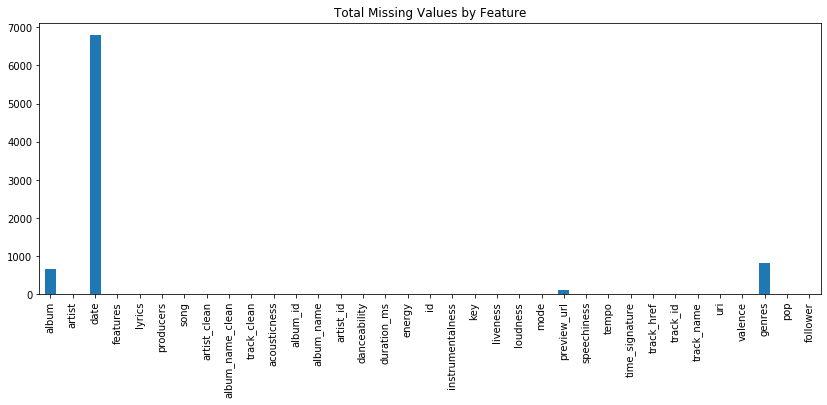

In [7]:
songs.isnull().sum().plot(kind='bar', figsize=(14,5));
plt.title('Total Missing Values by Feature');

### Preview_Url

In [8]:
songs = songs[songs.preview_url.notnull()]

### Album

In [9]:
len(songs.loc[songs.album.isnull(),'artist'].value_counts())

240

It looks like the missing albums are spread across a variety of artists. Because we've manually imputed albums previously, here we are going to make these empty strings

In [10]:
songs.album = songs.album.fillna('')
songs.album_name_clean = songs.album_name_clean.fillna('')

### Date

In [11]:
songs.date = pd.to_datetime(songs.date, errors = 'coerce')

In [13]:
songs.date = songs.date.dt.year

In [17]:
songs.loc[songs.date.notnull(), 'date'] = songs.loc[songs.date.notnull(), 'date'].astype(int)

In [19]:
average_date_df = pd.DataFrame(songs[songs.date.notnull()].groupby('artist_clean').mean()['date'])

In [20]:
average_date_df = average_date_df.reset_index()

In [21]:
average_date_df[average_date_df['artist_clean'] == '100s'].date

1    2013.454545
Name: date, dtype: float64

In [129]:
songs.date = songs.date.fillna(songs.artist_clean)

In [22]:
songs.date = songs.date.map(lambda x: average_date_df[average_date_df['artist_clean'] == x].date if type(x)==str else x)

In [23]:
songs.date = songs.date.map(lambda x: 0 if type(x)==str else x)

In [24]:
songs.date = songs.date.fillna(0)

### track

In [39]:
songs = songs[songs.track_clean.notnull()]

### Strip out non- rap

In [40]:
songs = songs[(songs.genres.str.contains('rap') | songs.genres.str.contains('hop'))]

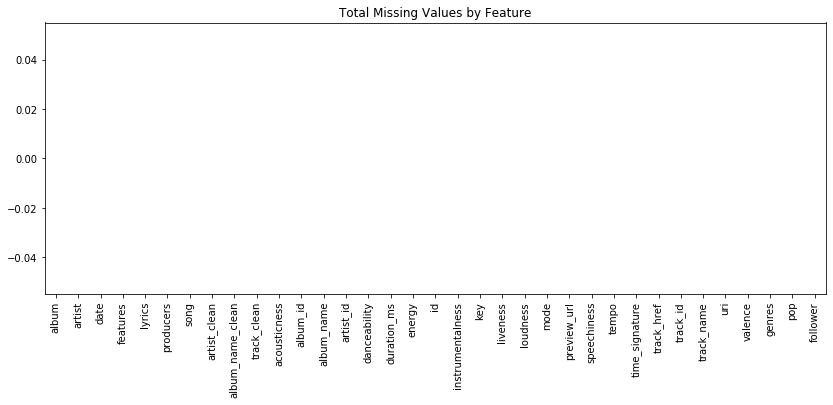

In [136]:
songs.isnull().sum().plot(kind='bar', figsize=(14,5));
plt.title('Total Missing Values by Feature');

### URI and Valence

In [41]:
songs.uri = songs.uri.fillna('')
songs.valence = songs.date.fillna(songs.valence.mean())

In [42]:
songs.to_csv('everything_ready_for_engineering_missing_genre.csv' ,index=False )